In [26]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from env import github_token, github_username
import acquire, prep, model

In [2]:
# plotting defaults

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire FreeCodeCamp README Dataset

In [3]:
# Load the data from json file
df = pd.read_json('data.json')

# Print the shape of the df
print(df.shape)

# Take a peek at the dataset
df.head()

(105, 3)


,repo,language,readme_contents
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
2,freeCodeCamp/nginx-config,None,# nginx-config\n\nConfig for our NGINX instanc...
3,freeCodeCamp/chat-config,HTML,Usage:\n\n1. Create a .env\n\n ```txt\n RO...
4,freeCodeCamp/devdocs,Ruby,# [DevDocs](https://devdocs.io) — API Document...


In [4]:
# Quick summarize df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             105 non-null    object
 1   language         97 non-null     object
 2   readme_contents  99 non-null     object
dtypes: object(3)
memory usage: 3.3+ KB


**Takeaways**
- Missing values are found in the columns 'language' and 'readme_contents'.
- For MVP, we decide to drop the records with missing values. 

## Wrangle README Datasets

In [5]:
# Drop the missing values
df = df.dropna()

# Print the shape of the df
df.shape

(92, 3)

In [6]:
# Clean the text by helper function
# Exlude words: 'freecodecamp', 'repository', 'run', 'test', 'use', 'using'
df = prep.prep_data(df, 'readme_contents', 
                    extra_words=['freecodecamp', 'repository', 'run', 'test', 'use', 'using'],
                    exclude_words=[])

# Print the shape
print(df.shape)

# Take a peek at the clean data
df.head()

(92, 6)


,repo,language,readme_contents,stemmed,lemmatized,clean
0,freeCodeCamp/chapter,TypeScript,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...
1,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
3,freeCodeCamp/chat-config,HTML,Usage:\n\n1. Create a .env\n\n ```txt\n RO...,usag 1 creat a env txt rocketchat_versionlates...,usage 1 create a env txt rocketchat_versionlat...,usage 1 create env txt rocketchat_versionlates...
4,freeCodeCamp/devdocs,Ruby,# [DevDocs](https://devdocs.io) — API Document...,devdocshttpsdevdocsio api document browser bui...,devdocshttpsdevdocsio api documentation browse...,devdocshttpsdevdocsio api documentation browse...
5,freeCodeCamp/news-theme,Handlebars,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...


In [7]:
# Quick summarize dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 104
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             92 non-null     object
 1   language         92 non-null     object
 2   readme_contents  92 non-null     object
 3   stemmed          92 non-null     object
 4   lemmatized       92 non-null     object
 5   clean            92 non-null     object
dtypes: object(6)
memory usage: 5.0+ KB


## Quick Exploration
- Detailed Exploration could be find in the autin_scratch.ipynb

In [8]:
# Compute the relative frequency in each language
df.language.value_counts(normalize=True)

JavaScript    0.543478
Python        0.141304
HTML          0.130435
CSS           0.065217
Shell         0.032609
R             0.021739
Ruby          0.021739
TypeScript    0.021739
Handlebars    0.010870
SCSS          0.010870
Name: language, dtype: float64

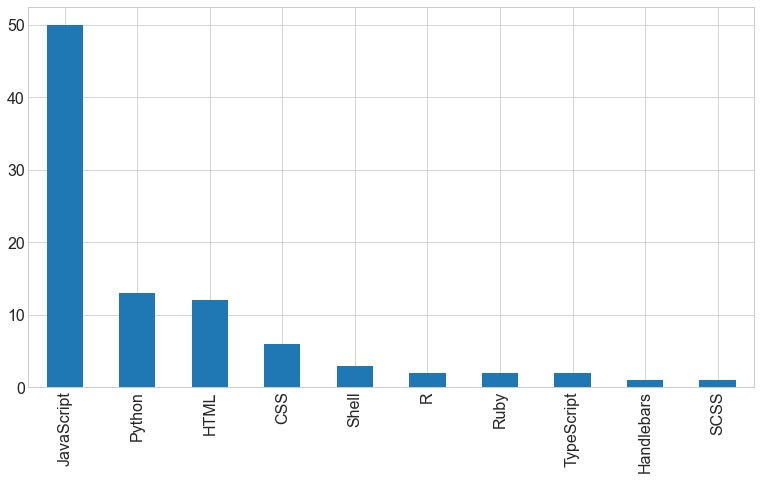

In [9]:
# Viz the distribution of the languages

df.language.value_counts().plot(kind='bar')
plt.show()

**Takeaways**
- About half of the languages are written in JavaScript. 

## Additional Wrangling

In [10]:
# Convert languages into js or not
df.language = df.language.apply(lambda i: 'js' if i == 'JavaScript' else 'other')

In [11]:
# Take a peek at the df
df.head()

,repo,language,readme_contents,stemmed,lemmatized,clean
0,freeCodeCamp/chapter,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...
1,freeCodeCamp/freeCodeCamp,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
3,freeCodeCamp/chat-config,other,Usage:\n\n1. Create a .env\n\n ```txt\n RO...,usag 1 creat a env txt rocketchat_versionlates...,usage 1 create a env txt rocketchat_versionlat...,usage 1 create env txt rocketchat_versionlates...
4,freeCodeCamp/devdocs,other,# [DevDocs](https://devdocs.io) — API Document...,devdocshttpsdevdocsio api document browser bui...,devdocshttpsdevdocsio api documentation browse...,devdocshttpsdevdocsio api documentation browse...
5,freeCodeCamp/news-theme,other,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...


In [12]:
# Add column words

df['words'] = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc)\
               .split() for doc in df.lemmatized]

# Take a peek at the new df
df.head(2)

,repo,language,readme_contents,stemmed,lemmatized,clean,words
0,freeCodeCamp/chapter,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."
1,freeCodeCamp/freeCodeCamp,js,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,"[freecodecamporg, social, bannerhttpss3amazona..."


In [13]:
# Drop the column repo
df.drop(columns = 'repo', inplace=True)

# Take a peek at the df
df.head(1)

,language,readme_contents,stemmed,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcom to chapter all contributorshttpsimgshie...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


In [14]:
# Drop the stemmed column
df.drop(columns='stemmed', inplace=True)

# Take a peek at the df
df.head(1)

,language,readme_contents,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


In [15]:
# Rename the columns
df.columns = ['label', 'text', 'lemmatized', 'clean', 'words']

# Take a peek at the df
df.head(1)

,label,text,lemmatized,clean,words
0,other,# Welcome to Chapter\n[![All Contributors](htt...,welcome to chapter all contributorshttpsimgshi...,welcome chapter contributorshttpsimgshieldsiob...,"[welcome, to, chapter, all, contributorshttpsi..."


## Modeling
### Goal: to predict the language used for the repo is JavaScript or not (binary classification).

#### Split into train and validate

In [17]:
train, validate = train_test_split(df[['label', 'clean']], 
                                   stratify=df.label, 
                                   test_size=.2,
                                   random_state=123)

In [18]:
print(train.label.value_counts())
print(validate.label.value_counts())
train.head()

js       40
other    33
Name: label, dtype: int64
js       10
other     9
Name: label, dtype: int64


,label,clean
78,js,longer please search mono repohttpsgithubcomfr...
69,js,open source good directory directory freecodec...
3,other,usage 1 create env txt rocketchat_versionlates...
73,other,happy new year 2017 simple website host open20...
86,js,pm2 pager get notification exception pm2 nodem...


#### Compute the baseline accuracy

In [19]:
labels = pd.concat([train.label.value_counts(), # get total counts of js vs other
                    train.label.value_counts(normalize=True)], axis=1) # getting the prop of js vs other
labels.columns = ['n', 'percent']
labels

,n,percent
js,40,0.547945
other,33,0.452055


**Takeaway**:
- The baseline accuracy is 55%. 

### Feature Generation: Bag of Words

In [22]:
# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=15, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.clean)

# Get dictionary. 
vectorizer.get_feature_names()

['add',
 'build',
 'code',
 'create',
 'data',
 'development',
 'file',
 'following',
 'like',
 'make',
 'new',
 'npm',
 'open',
 'project',
 'set',
 'test',
 'url']

In [23]:
# Transform each sentences in vector space.
X_train_bow = vectorizer.transform(train.clean)
X_validate_bow = vectorizer.transform(validate.clean)

In [25]:
# this is just to see the array of 0's and 1's
X_train_bowarray = X_train_bow.toarray()
X_validate_bowarray = X_validate_bow.toarray()
X_train_bowarray[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# # Show sentences and vector space representation.
# # purely to visualize what's happening.
# for i, v in zip(train.clean, bow_array):
#     print(i)
#     print(v)

### Feature Generation: TF-IDF

In [33]:
# Transform the clean text into sparse matrix

tfidf = TfidfVectorizer(stop_words='english', min_df=15, 
                        ngram_range=(1,2), 
                        binary=True)

# Fit on cleaned text in train
tfidf = tfidf.fit(train.clean)

# Transform the train and validate
X_train_tfidf = tfidf.transform(train.clean)
X_vaildate_tfidf = tfidf.transform(validate.clean)

# Take a peek at 
X_train_tfidf

<73x17 sparse matrix of type '<class 'numpy.float64'>'
	with 312 stored elements in Compressed Sparse Row format>

In [34]:
# Conver to datafame
pd.DataFrame(tfidf_sparse_matrix.todense(), columns=tfidf.get_feature_names()).head()

,add,build,code,create,data,development,file,following,like,make,new,npm,open,project,set,test,url
0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.303177,0.310124,0.284341,0.27863,0.317468,0.0,0.317468,0.325258,0.0,0.303177,0.0,0.325258,0.310124,0.228409,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [35]:
# Get vocabularies.
tfidf.vocabulary_

{'open': 12,
 'project': 13,
 'add': 0,
 'file': 6,
 'build': 1,
 'data': 4,
 'make': 9,
 'npm': 11,
 'create': 3,
 'following': 7,
 'code': 2,
 'new': 10,
 'test': 15,
 'like': 8,
 'set': 14,
 'development': 5,
 'url': 16}

In [42]:
# Transform to document-term matrix
X_train_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3031775 , 0.31012434, 0.28434109, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.27946988, 0.        , 0.26210642, ..., 0.27339479, 0.26761617,
        0.29982351],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.59392899, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# # Show sentences and vector space representation.
# # 
# # (A, B) C
# # A : Document Index
# # B : Specific word-vector index
# # C : TF-IDF score
# for i, v in zip(train.clean, vector_spaces):
#     print(i)
#     print(v)

### Model on Train using LogisticRegression

In [38]:
# create our y dataset
y_train = train['label']
y_validate = validate['label']

#### Model on bow features

In [39]:
# Create the LogisticRegressioin object and fit on train
lm = LogisticRegression().fit(X_train_bow, y_train)

# Predict the labels for the train
y_pred = lm.predict(X_train_bow)

In [40]:
# Compute the confusion matrix
confusion_matrix(train.label, y_pred)

array([[36,  4],
       [14, 19]])

In [41]:
# Compute the performance metrics
print(classification_report(train.label, y_pred))

              precision    recall  f1-score   support

          js       0.72      0.90      0.80        40
       other       0.83      0.58      0.68        33

    accuracy                           0.75        73
   macro avg       0.77      0.74      0.74        73
weighted avg       0.77      0.75      0.75        73



**Takeaways**
- when min_df = 20: 
    - The accuracy is 67%, which beats the baseline 
    - The lm performs better on predicting the JavaScript than other language.
- when min_df = 10:
    - The accuracy is 81%, which get improved by 14%. 

#### Model TFIDF

In [ ]:
# Fit the LogisticRegression on TFIDF features
lm_tfidf = LogisticRegression().fit(X_tfidf, y)

# Predic the labels
y_pred = lm_tfidf.predict(X_tfidf)

In [ ]:
# Compute the confusion matrix
confusion_matrix(train.label, y_pred)

In [ ]:
# Compute the performance metrics
print(classification_report(train.label, y_pred))

**Takeaways**
- When min_df = 20
    - The accuracy is 0.64, which also beats the baseline.
    - Simiar to bow features, the lm performs better on predicting the JavaScript than other language.
- When min_df = 10
    - The accuracy is 0.75, which get improved by 10%. 

### Model on Validate

In [ ]:
# Create the bow and tfidf features for the validate

X_bow_validate = vectorizer.transform(validate.clean)
X_tfidf_validate = tfidf.transform(validate.clean)

In [ ]:
# Predict the labels basded on both features. 

y_pred_bow = lm.predict(X_bow_validate)
y_pred_tfidf = lm_tfidf.predict(X_tfidf_validate)

In [ ]:
# Compute the performance metrics for bow features. 
print(classification_report(validate.label, y_pred_bow))

In [ ]:
# Compute the performance metrics for tfidf features.
print(classification_report(validate.label, y_pred_tfidf))

**Takeaways**
- The accuracy drops back to 63% for bow features and below the baseline for tfidf features, which indicates overfitting issue but still beats the baseline.
- Other metrics such as precision and recall drop about by 10-20%.

**Future Works**:
1. To enlarge the dataset.
2. Try different classification algorithms.
3. To exclude the 'run', 'repository' and similar words to reduce the noise. 

### How does the min_df affect the model performance?

In [ ]:
# Loop through 

metrics = []
lr = LogisticRegression()

for i in range (5, 21):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=i, 
                                 ngram_range=(1,2), 
                                 binary=True)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics.append(d2)

In [ ]:
# Conver the metrics into dataframe

metrics = pd.DataFrame(metrics)
metrics.head()

In [ ]:
# Rename the columns
metrics.rename(columns={'model_type':'min_df'}, inplace=True)

In [ ]:
# Scatterplot the accuracy against the min_df 

sns.scatterplot(data=metrics, x='min_df', y='accuracy', hue='data_type')
plt.axhline(y=0.54)
plt.show()

In [ ]:
feature_names14 = CountVectorizer(stop_words='english', 
                                 min_df=14, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [ ]:
feature_names15 = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,2), 
                                 binary=True).fit(train.clean).get_feature_names()

In [ ]:
set(feature_names14) - set(feature_names15)

### How does ngram_range affect the model performance?

In [ ]:
# Loop through 

metrics = []
lr = LogisticRegression()

for i in range (2,6):
    vectorizer = CountVectorizer(stop_words='english', 
                                 min_df=15, 
                                 ngram_range=(1,i), 
                                 binary=True)
    print(vectorizer)
    vectorizer = vectorizer.fit(train.clean)
    X_train = vectorizer.transform(train.clean)
    X_validate = vectorizer.transform(validate.clean)
    lr = lr.fit(X_train, y)
    y_pred_train = lr.predict(X_train)
    y_pred_validate = lr.predict(X_validate)
    d1 = model.estimator_report(i, 'train', train.label, y_pred_train)
    metrics.append(d1)
    d2 = model.estimator_report(i, 'validate', validate.label, y_pred_validate)
    metrics.append(d2)

In [ ]:
metrics = pd.DataFrame(metrics)
metrics

In [ ]:
# Rename the columns
metrics.rename(columns={'model_type':'ngram_range'}, inplace=True)

In [ ]:
# Scatterplot the accuracy against the min_df 

sns.scatterplot(data=metrics, x='ngram_range', y='accuracy', hue='data_type')
plt.axhline(y=0.54)
plt.show()

### Model train by Naive Bayes

In [ ]:
# Create the naive bayes object by default
gnb = GaussianNB()

# Fit on train on bow and ti

gnb = gnb.fit(X_bow.toarray(), y)
gnb

y_pred = gnb.predict(X_bow.toarray())

In [ ]:
# Compute the performance metrics
print(classification_report(train.label, y_pred))